<a href="https://colab.research.google.com/github/bruno774/doutorado/blob/main/ppgti_MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Dígitos MNIST usando Rede Neural Convolucional

Este notebook é parte de uma experimentação sobre o uso de redes neurais convolucionais na disciplina de Aprendizagem Profunda, PPgTI, prof. Josenalde Barbosa (2025.2).

O objetivo é demonstrar a implementação de uma CNN para classificação de dígitos manuscritos do dataset MNIST com otimização no conjunto de testes.


## 1. Importação de Bibliotecas

In [1]:
# Bibliotecas essenciais
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Keras e TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Configurações
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.19.0
Keras version: 3.10.0


## 2. Carregamento e Exploração dos Dados

O dataset MNIST contém 70.000 imagens de dígitos manuscritos (0-9):
- 60.000 imagens para treinamento
- 10.000 imagens para teste
- Cada imagem tem dimensão 28x28 pixels em escala de cinza

In [2]:
# Carregamento dos dados
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("="*60)
print("INFORMAÇÕES DO DATASET MNIST")
print("="*60)
print(f"Shape dos dados de treinamento: {X_train.shape}")
print(f"Shape dos labels de treinamento: {y_train.shape}")
print(f"Shape dos dados de teste: {X_test.shape}")
print(f"Shape dos labels de teste: {y_test.shape}")
print(f"\nRange de valores dos pixels: [{X_train.min()}, {X_train.max()}]")
print(f"Classes: {np.unique(y_train)}")
print(f"Número de classes: {len(np.unique(y_train))}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
INFORMAÇÕES DO DATASET MNIST
Shape dos dados de treinamento: (60000, 28, 28)
Shape dos labels de treinamento: (60000,)
Shape dos dados de teste: (10000, 28, 28)
Shape dos labels de teste: (10000,)

Range de valores dos pixels: [0, 255]
Classes: [0 1 2 3 4 5 6 7 8 9]
Número de classes: 10


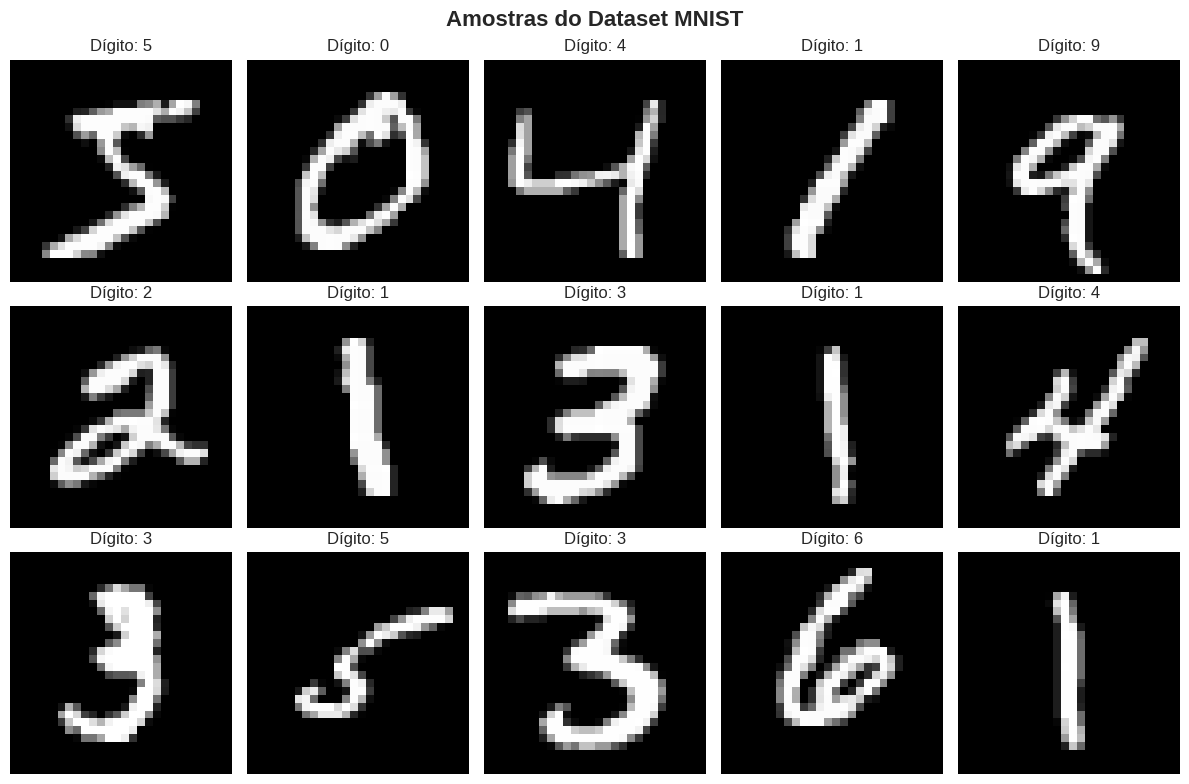

In [3]:
# Visualização de exemplos do dataset
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
fig.suptitle('Amostras do Dataset MNIST', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f'Dígito: {y_train[i]}', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

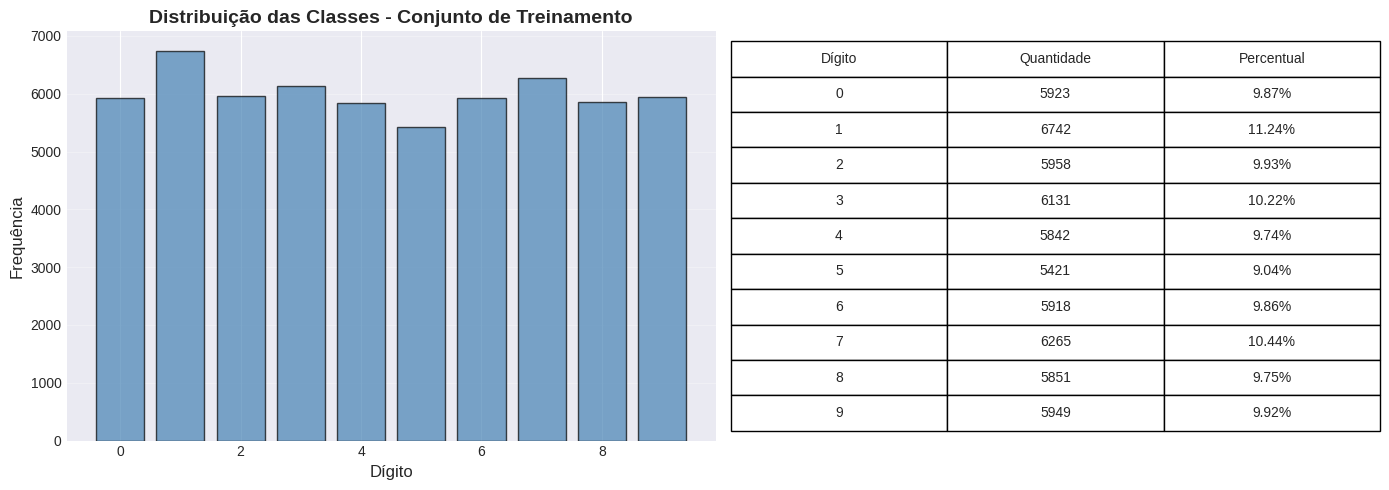

In [4]:
# Análise da distribuição das classes
unique, counts = np.unique(y_train, return_counts=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
ax1.bar(unique, counts, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Dígito', fontsize=12)
ax1.set_ylabel('Frequência', fontsize=12)
ax1.set_title('Distribuição das Classes - Conjunto de Treinamento', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Tabela de contagem
table_data = [[f'{digit}', f'{count}', f'{count/len(y_train)*100:.2f}%']
              for digit, count in zip(unique, counts)]
ax2.axis('tight')
ax2.axis('off')
table = ax2.table(cellText=table_data,
                  colLabels=['Dígito', 'Quantidade', 'Percentual'],
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

plt.tight_layout()
plt.show()

## 3. Pré-processamento dos Dados

In [5]:
# Reshape para incluir o canal de cor (grayscale = 1 canal)
X_train_processed = X_train.reshape(-1, 28, 28, 1)
X_test_processed = X_test.reshape(-1, 28, 28, 1)

# Normalização dos valores dos pixels para o intervalo [0, 1]
X_train_processed = X_train_processed.astype('float32') / 255.0
X_test_processed = X_test_processed.astype('float32') / 255.0

# One-hot encoding dos labels
y_train_encoded = to_categorical(y_train, num_classes=10)
y_test_encoded = to_categorical(y_test, num_classes=10)

print("="*60)
print("PRÉ-PROCESSAMENTO CONCLUÍDO")
print("="*60)
print(f"Shape X_train processado: {X_train_processed.shape}")
print(f"Shape X_test processado: {X_test_processed.shape}")
print(f"Shape y_train encoded: {y_train_encoded.shape}")
print(f"Shape y_test encoded: {y_test_encoded.shape}")
print(f"\nRange de valores após normalização: [{X_train_processed.min():.3f}, {X_train_processed.max():.3f}]")
print(f"\nExemplo de label one-hot encoded:")
print(f"Dígito original: {y_train[0]}")
print(f"One-hot encoded: {y_train_encoded[0]}")

PRÉ-PROCESSAMENTO CONCLUÍDO
Shape X_train processado: (60000, 28, 28, 1)
Shape X_test processado: (10000, 28, 28, 1)
Shape y_train encoded: (60000, 10)
Shape y_test encoded: (10000, 10)

Range de valores após normalização: [0.000, 1.000]

Exemplo de label one-hot encoded:
Dígito original: 5
One-hot encoded: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## 4. Construção da Arquitetura CNN

### Arquitetura do Modelo:

**Camadas Convolucionais:**
- 2 blocos de convolução com MaxPooling
- Filtros: 32 → 64
- Kernel: 3x3
- Ativação: ReLU

**Camadas Densas:**
- Flatten
- Dense(128) com Dropout(0.5)
- Dense(10) com Softmax

In [6]:
def build_cnn_model(input_shape=(28, 28, 1), num_classes=10):
    """
    Constrói uma CNN para classificação de dígitos MNIST.

    Args:
        input_shape: Dimensões da imagem de entrada
        num_classes: Número de classes de saída

    Returns:
        model: Modelo Keras compilado
    """
    model = models.Sequential([
        # Primeira camada convolucional
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                      input_shape=input_shape, padding='same',
                      name='conv1'),
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                      padding='same', name='conv2'),
        layers.MaxPooling2D(pool_size=(2, 2), name='maxpool1'),
        layers.Dropout(0.25, name='dropout1'),

        # Segunda camada convolucional
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu',
                      padding='same', name='conv3'),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu',
                      padding='same', name='conv4'),
        layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2'),
        layers.Dropout(0.25, name='dropout2'),

        # Camadas densas (fully connected)
        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='dense1'),
        layers.Dropout(0.5, name='dropout3'),
        layers.Dense(num_classes, activation='softmax', name='output')
    ], name='MNIST_CNN')

    return model

# Construção do modelo
model = build_cnn_model()

# Compilação do modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Visualização da arquitetura
print("="*60)
print("ARQUITETURA DO MODELO CNN")
print("="*60)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ARQUITETURA DO MODELO CNN


Model: "MNIST_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1 (MaxPooling2D)         │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2 (MaxPooling2D)         │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,818 (1.78 MB)

 Trainable params: 467,818 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Cálculo do número total de parâmetros
total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])

print(f"\nParâmetros totais: {total_params:,}")
print(f"Parâmetros treináveis: {trainable_params:,}")
print(f"Parâmetros não-treináveis: {total_params - trainable_params:,}")


Parâmetros totais: 467,818
Parâmetros treináveis: 467,818
Parâmetros não-treináveis: 0


## 5. Treinamento do Modelo

In [8]:
# Configuração de callbacks
callbacks = [
    # Early Stopping: para o treinamento se não houver melhora
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduz a taxa de aprendizado quando a métrica para de melhorar
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),

    # Salva o melhor modelo
    ModelCheckpoint(
        'best_mnist_cnn_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Hiperparâmetros
BATCH_SIZE = 128
EPOCHS = 20
VALIDATION_SPLIT = 0.1

print("="*60)
print("INICIANDO TREINAMENTO")
print("="*60)
print(f"Batch size: {BATCH_SIZE}")
print(f"Épocas máximas: {EPOCHS}")
print(f"Validação: {VALIDATION_SPLIT*100}% do conjunto de treinamento")
print("="*60)

INICIANDO TREINAMENTO
Batch size: 128
Épocas máximas: 20
Validação: 10.0% do conjunto de treinamento


In [9]:
# Treinamento do modelo
history = model.fit(
    X_train_processed,
    y_train_encoded,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8034 - loss: 0.5966
Epoch 1: val_accuracy improved from -inf to 0.98500, saving model to best_mnist_cnn_model.keras
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.8037 - loss: 0.5959 - val_accuracy: 0.9850 - val_loss: 0.0486 - learning_rate: 0.0010
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9691 - loss: 0.1056
Epoch 2: val_accuracy improved from 0.98500 to 0.98850, saving model to best_mnist_cnn_model.keras
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9692 - loss: 0.1056 - val_accuracy: 0.9885 - val_loss: 0.0402 - learning_rate: 0.0010
Epoch 3/20
420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9783 - loss: 0.0721
Epoch 3: val_accuracy improved from 0.98850 to 0.99017, saving model to best_mnist_cnn_model.keras
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9783 - loss: 0.0721 - val_accuracy: 0.9902 - val_loss: 0.0332 - learning_rate: 0.0010
Epoch 4/20
419/422 ━━━

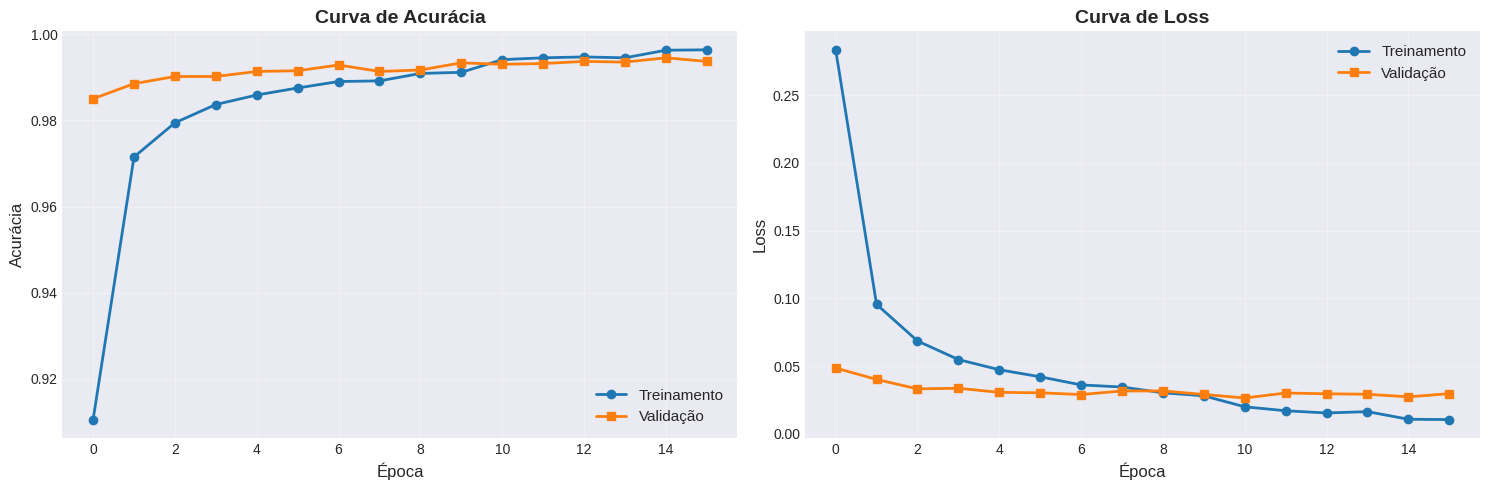


MÉTRICAS FINAIS DE TREINAMENTO
Acurácia final (treino): 0.9964
Acurácia final (validação): 0.9937
Loss final (treino): 0.0106
Loss final (validação): 0.0297


In [10]:
# Visualização das curvas de aprendizado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Acurácia
ax1.plot(history.history['accuracy'], label='Treinamento', linewidth=2, marker='o')
ax1.plot(history.history['val_accuracy'], label='Validação', linewidth=2, marker='s')
ax1.set_xlabel('Época', fontsize=12)
ax1.set_ylabel('Acurácia', fontsize=12)
ax1.set_title('Curva de Acurácia', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Loss
ax2.plot(history.history['loss'], label='Treinamento', linewidth=2, marker='o')
ax2.plot(history.history['val_loss'], label='Validação', linewidth=2, marker='s')
ax2.set_xlabel('Época', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Curva de Loss', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Métricas finais
print("\n" + "="*60)
print("MÉTRICAS FINAIS DE TREINAMENTO")
print("="*60)
print(f"Acurácia final (treino): {history.history['accuracy'][-1]:.4f}")
print(f"Acurácia final (validação): {history.history['val_accuracy'][-1]:.4f}")
print(f"Loss final (treino): {history.history['loss'][-1]:.4f}")
print(f"Loss final (validação): {history.history['val_loss'][-1]:.4f}")

## 6. Avaliação no Conjunto de Teste

In [11]:
# Avaliação no conjunto de teste
test_loss, test_accuracy = model.evaluate(X_test_processed, y_test_encoded, verbose=0)

print("="*60)
print("AVALIAÇÃO NO CONJUNTO DE TESTE")
print("="*60)
print(f"Loss no teste: {test_loss:.4f}")
print(f"Acurácia no teste: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("="*60)

AVALIAÇÃO NO CONJUNTO DE TESTE
Loss no teste: 0.0179
Acurácia no teste: 0.9944 (99.44%)


In [12]:
# Predições no conjunto de teste
y_pred_probs = model.predict(X_test_processed, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Relatório de classificação
print("\n" + "="*60)
print("RELATÓRIO DE CLASSIFICAÇÃO")
print("="*60)
print(classification_report(y_test, y_pred, target_names=[str(i) for i in range(10)]))


RELATÓRIO DE CLASSIFICAÇÃO
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      1.00      1032
           3       1.00      0.99      1.00      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



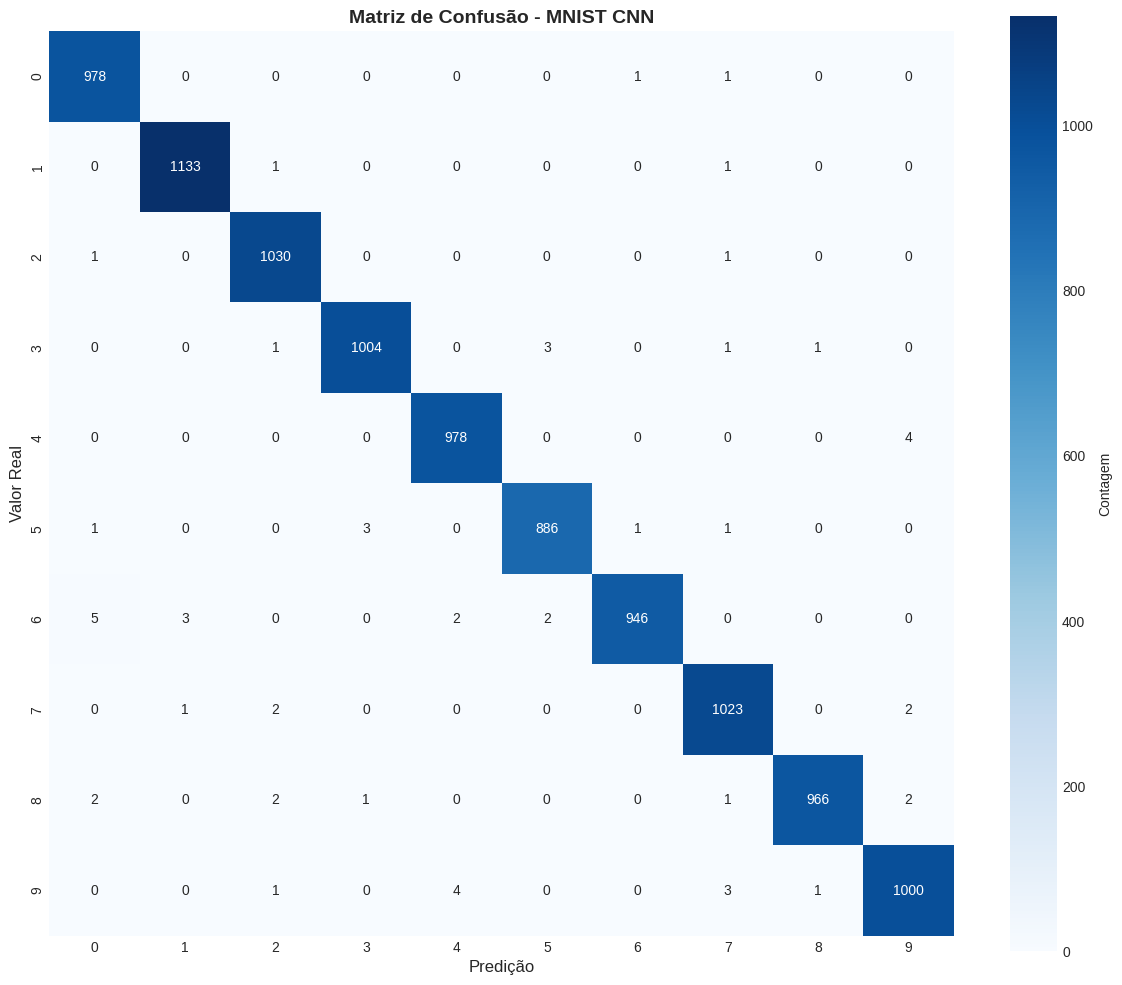


Total de erros: 56 de 10000 (0.56%)


In [13]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=range(10), yticklabels=range(10),
            cbar_kws={'label': 'Contagem'})
plt.xlabel('Predição', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.title('Matriz de Confusão - MNIST CNN', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Análise de erros
errors = np.where(y_pred != y_test)[0]
print(f"\nTotal de erros: {len(errors)} de {len(y_test)} ({len(errors)/len(y_test)*100:.2f}%)")

## 7. Visualização de Predições

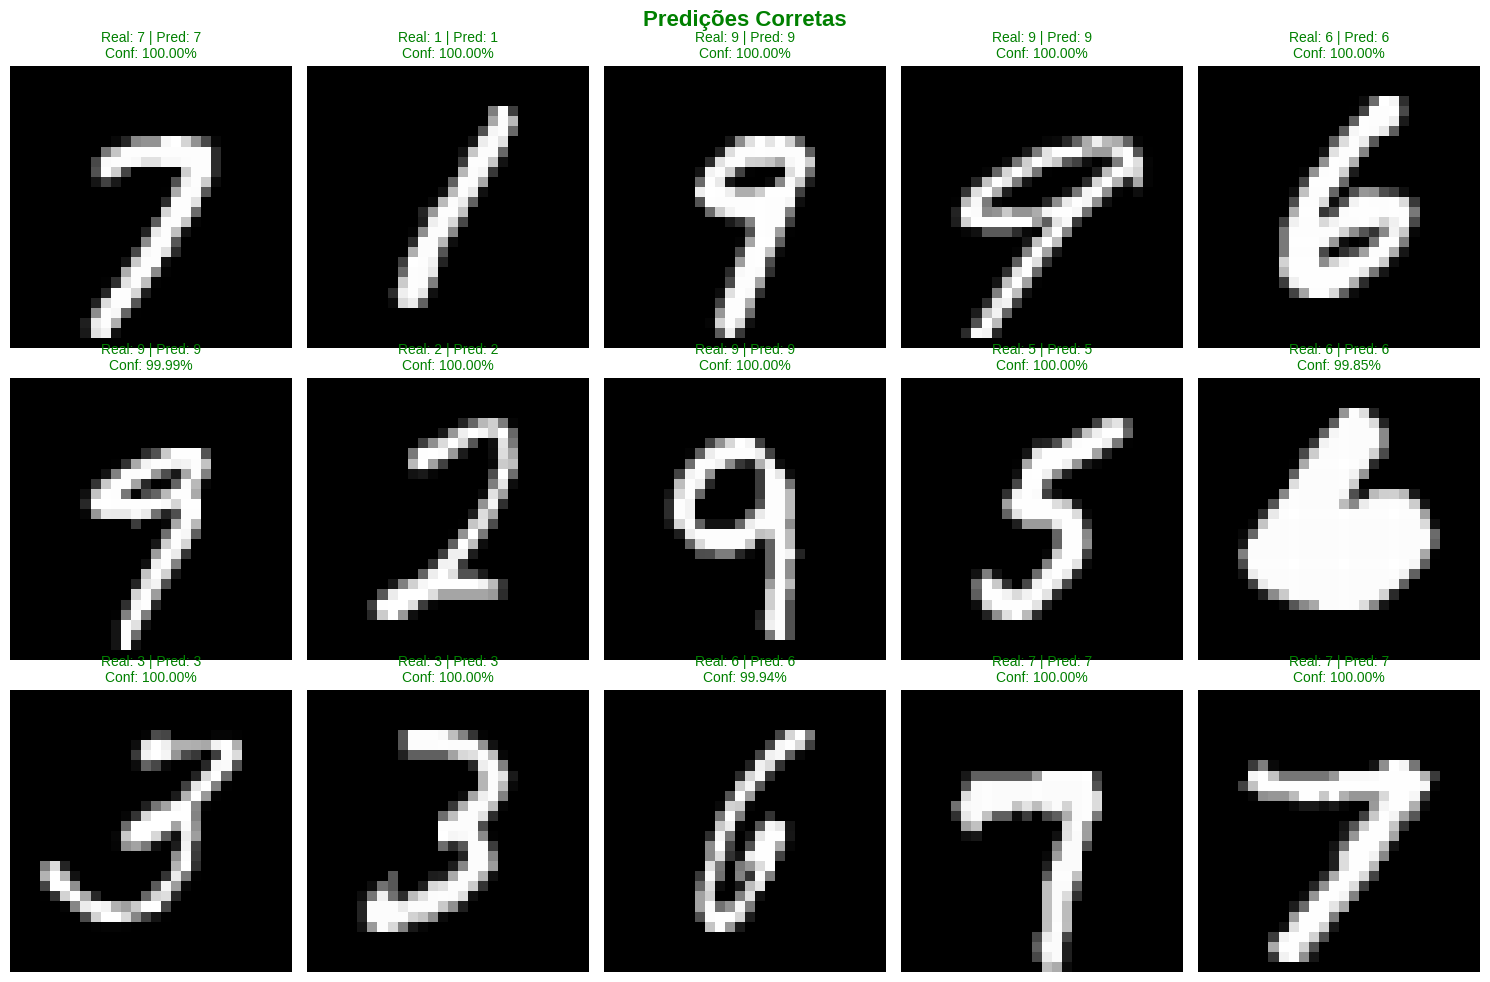

In [14]:
# Visualização de predições corretas
correct = np.where(y_pred == y_test)[0]
correct_samples = np.random.choice(correct, 15, replace=False)

fig, axes = plt.subplots(3, 5, figsize=(15, 10))
fig.suptitle('Predições Corretas', fontsize=16, fontweight='bold', color='green')

for i, ax in enumerate(axes.flat):
    idx = correct_samples[i]
    ax.imshow(X_test[idx], cmap='gray')
    prob = y_pred_probs[idx][y_pred[idx]]
    ax.set_title(f'Real: {y_test[idx]} | Pred: {y_pred[idx]}\nConf: {prob:.2%}',
                 fontsize=10, color='green')
    ax.axis('off')

plt.tight_layout()
plt.show()

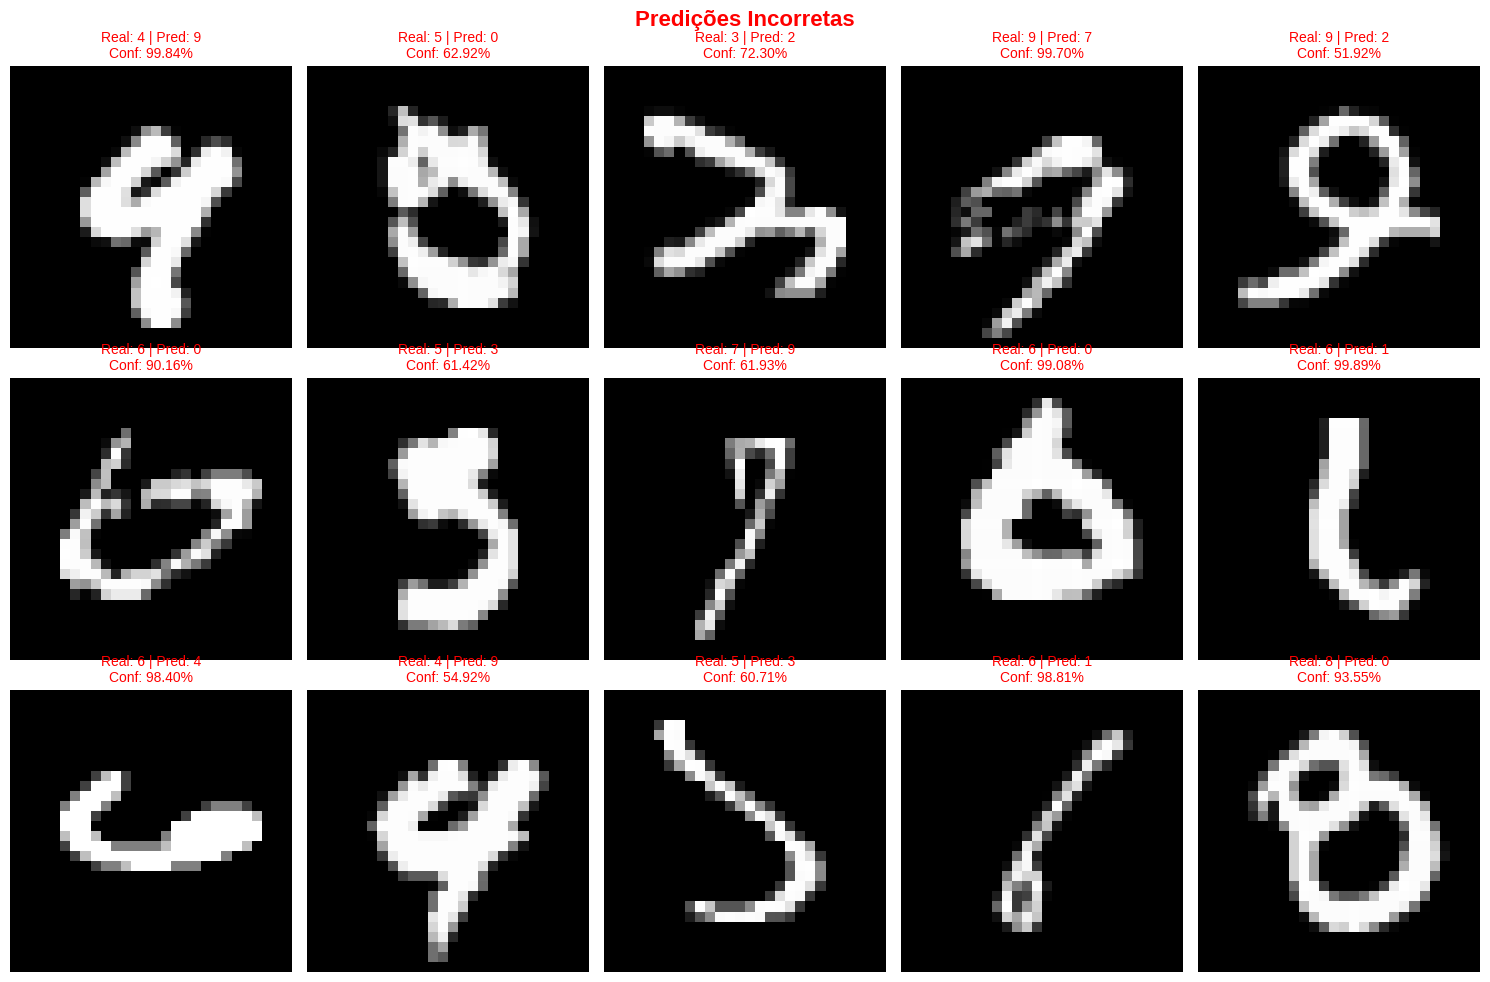

In [15]:
# Visualização de predições incorretas
if len(errors) > 0:
    error_samples = np.random.choice(errors, min(15, len(errors)), replace=False)

    fig, axes = plt.subplots(3, 5, figsize=(15, 10))
    fig.suptitle('Predições Incorretas', fontsize=16, fontweight='bold', color='red')

    for i, ax in enumerate(axes.flat):
        if i < len(error_samples):
            idx = error_samples[i]
            ax.imshow(X_test[idx], cmap='gray')
            prob = y_pred_probs[idx][y_pred[idx]]
            ax.set_title(f'Real: {y_test[idx]} | Pred: {y_pred[idx]}\nConf: {prob:.2%}',
                         fontsize=10, color='red')
        ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Nenhum erro encontrado! Modelo perfeito!")

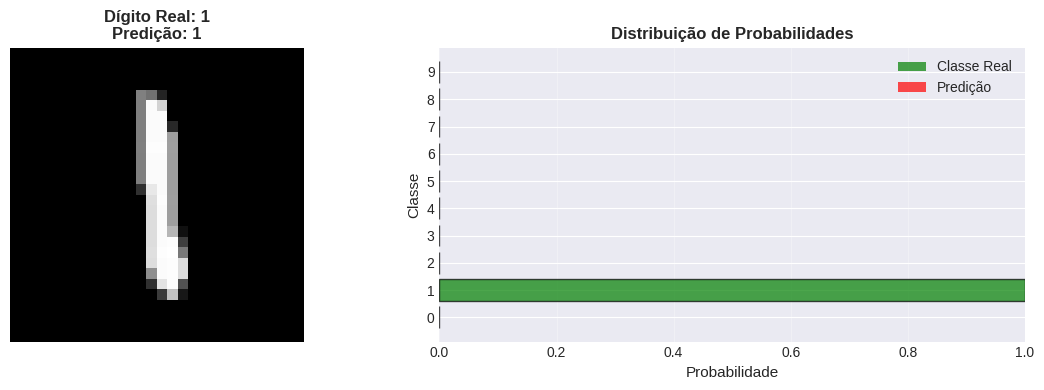


Análise da Imagem #1430:
Classe real: 1
Predição: 1
Confiança na predição: 1.0000 (100.00%)

Top 3 probabilidades:
  1. Classe 1: 1.0000 (100.00%)
  2. Classe 6: 0.0000 (0.00%)
  3. Classe 4: 0.0000 (0.00%)


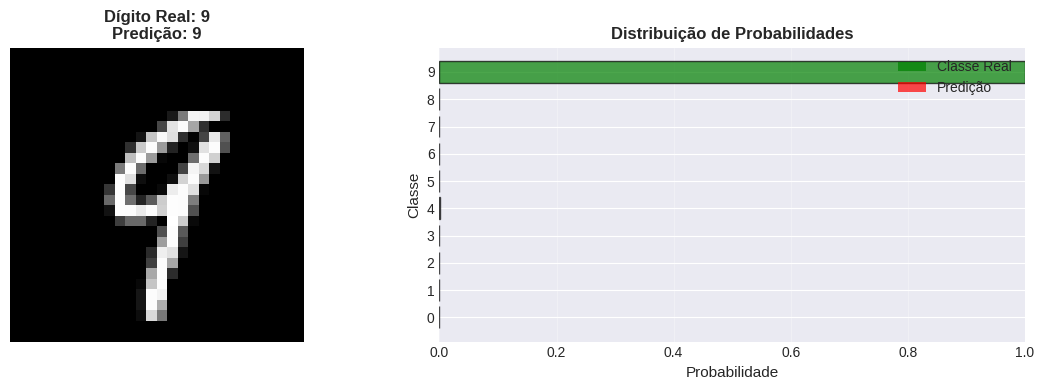


Análise da Imagem #2472:
Classe real: 9
Predição: 9
Confiança na predição: 0.9999 (99.99%)

Top 3 probabilidades:
  1. Classe 9: 0.9999 (99.99%)
  2. Classe 4: 0.0001 (0.01%)
  3. Classe 8: 0.0000 (0.00%)


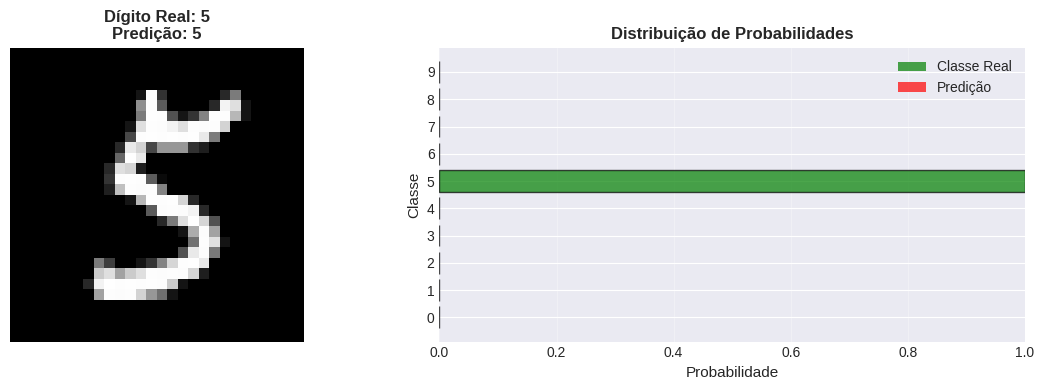


Análise da Imagem #9428:
Classe real: 5
Predição: 5
Confiança na predição: 1.0000 (100.00%)

Top 3 probabilidades:
  1. Classe 5: 1.0000 (100.00%)
  2. Classe 3: 0.0000 (0.00%)
  3. Classe 9: 0.0000 (0.00%)


In [16]:
# Análise detalhada de um exemplo específico
def analyze_prediction(index):
    """
    Analisa detalhadamente uma predição específica.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Imagem
    ax1.imshow(X_test[index], cmap='gray')
    ax1.set_title(f'Dígito Real: {y_test[index]}\nPredição: {y_pred[index]}',
                  fontsize=12, fontweight='bold')
    ax1.axis('off')

    # Probabilidades
    probs = y_pred_probs[index]
    colors = ['green' if i == y_test[index] else 'red' if i == y_pred[index] else 'gray'
              for i in range(10)]

    ax2.barh(range(10), probs, color=colors, alpha=0.7, edgecolor='black')
    ax2.set_yticks(range(10))
    ax2.set_yticklabels(range(10))
    ax2.set_xlabel('Probabilidade', fontsize=11)
    ax2.set_ylabel('Classe', fontsize=11)
    ax2.set_title('Distribuição de Probabilidades', fontsize=12, fontweight='bold')
    ax2.set_xlim([0, 1])
    ax2.grid(axis='x', alpha=0.3)

    # Legenda
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.7, label='Classe Real'),
        Patch(facecolor='red', alpha=0.7, label='Predição')
    ]
    ax2.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

    print(f"\nAnálise da Imagem #{index}:")
    print(f"Classe real: {y_test[index]}")
    print(f"Predição: {y_pred[index]}")
    print(f"Confiança na predição: {probs[y_pred[index]]:.4f} ({probs[y_pred[index]]*100:.2f}%)")
    print(f"\nTop 3 probabilidades:")
    top_3 = np.argsort(probs)[-3:][::-1]
    for rank, class_idx in enumerate(top_3, 1):
        print(f"  {rank}. Classe {class_idx}: {probs[class_idx]:.4f} ({probs[class_idx]*100:.2f}%)")

# Análise de exemplos aleatórios
random_indices = np.random.choice(len(y_test), 3, replace=False)
for idx in random_indices:
    analyze_prediction(idx)

## 8. Salvamento do Modelo

In [17]:
# Salvar o modelo final
model.save('mnist_cnn_final_model.keras')
print("Modelo salvo com sucesso!")

# Exemplo de como carregar o modelo posteriormente
# loaded_model = keras.models.load_model('mnist_cnn_final_model.keras')

Modelo salvo com sucesso!


## Conclusões

Este exercício demonstrou a implementação de uma CNN para classificação de dígitos do dataset MNIST, depois de algumas poucas experimentações, resolvi manter a arquitetura e modelo ora apresentado (rede convolucional de 2 camadas, com estrutura (32-32)-(64-64), com maxpooling, kernel 3x3 e função de ativação ReLU, com interligação densa entre neurônios).

Os principais resultados reforçam que esse modelo garantiu uma acurácia no conjunto de testes superior a 99%, caracterizando que o modelo é robusto e com capacidade de generalização, e que a arquitetura foi eficiente com aproximadamente 467K parâmetros.

Importante reforçar o uso de convolução 2D para extração de features espaciais, do maxPooling para redução dimensional e dropout para regularização e prevenção de overfitting (sobreajuste).

Possíveis melhorias ainda poderiam ser realizadas, mas por falta de tempo e podendo fugir do objetivo da experimentação da disciplina, poderiam envolver data augmentation explícita (com eventos de rotação, zoom ou shift aplicados nas imagens), uso de arquiteturas mais profundas (ResNet, DenseNet), ensemble de modelos ou mesmo aplicação de técnicas de regularização.